# Detection of changes in Satellite Images using PCA & K-Means






 **Framework for this notebook :**

1.difference image generation and Eigen vector space (EVS).

2.building the feature vector space (FVS).

3.clustering of the feature vector space and change map

In [ ]:
!pip install scipy==1.1.0

In [ ]:
!pip install rasterio

     |████████████████████████████████| 19.1MB 1.3MB/s 


In [ ]:
pip install "scikit_learn==0.22.2.post1"

     |████████████████████████████████| 7.1MB 6.7MB/s 
  Found existing installation: scikit-learn 0.24.2
    Uninstalling scikit-learn-0.24.2:
      Successfully uninstalled scikit-learn-0.24.2


In [ ]:
from scipy.misc import imread, imsave, imresize
import numpy as np
import rasterio
from osgeo import gdal

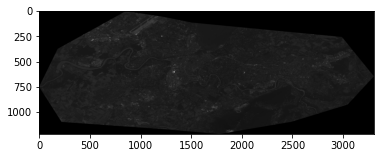

In [ ]:
   
options_list = [
    '-ot Byte',
    '-of JPEG',
    '-b 1', #1 band (gray scale)
    '-scale'
]           

options_string = " ".join(options_list)
    
gdal.Translate(
    '/content/drive/MyDrive/sat_images (1)/places/Amman_Jordan_2015/oldpic.jpg',
    '/content/drive/MyDrive/sat_images (1)/places/Amman_Jordan_2015/sentinel2_image_cropped.tif',
    options=options_string
)

f=cv2.imread("/content/drive/MyDrive/sat_images (1)/places/Amman_Jordan_2015/oldpic.jpg")
plt.imshow(f)
plt.show()

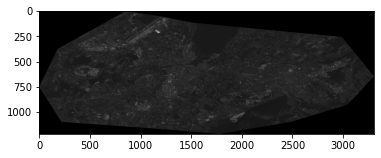

In [ ]:
   
options_list = [
    '-ot Byte',
    '-of JPEG',
    '-b 1',
    '-scale'
]           

options_string = " ".join(options_list)
    
gdal.Translate(
    '/content/drive/MyDrive/sat_images (1)/places/Amman_Jordan_2020/newpic.jpg',
    '/content/drive/MyDrive/sat_images (1)/places/Amman_Jordan_2020/sentinel2_image_cropped.tif',
    options=options_string
)

f=cv2.imread("/content/drive/MyDrive/sat_images (1)/places/Amman_Jordan_2020/newpic.jpg")
plt.imshow(f)
plt.show()

#Difference image and the Eigen vector space

 The difference image is the absolute valued differences of the intensity values of the corresponding pixels of the 2 grayscale images.  


In [ ]:
image1 = imread("/content/drive/MyDrive/sat_images (1)/places/Amman_Jordan_2015/oldpic.jpg")
image2 = imread("/content/drive/MyDrive/sat_images (1)/places/Amman_Jordan_2020/newpic.jpg")
new_size = np.asarray(image1.shape) / 5
new_size = new_size.astype(int) * 5
image1 = imresize(image1, (new_size)).astype(np.int16)
image2 = imresize(image2, (new_size)).astype(np.int16)
diff_image = abs(image1 - image2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.
  


# *Principal Component Analysis *

PCA is a technique to emphasise variation and bring out strong patterns in a data set. It converts a set of observations of possibly correlated variables into a set of values of linearly uncorrelated variables called principal components. It is a widely used method for dimensionality reduction.

In find_vector_set function , we take non-overlapping blocks of size 5 x 5 from the difference image and flatten them into row vectors, a Collection of these row vectors forms a vector set.

In [ ]:
def find_vector_set(diff_image, new_size):
 
    i = 0
    j = 0
    vector_set = np.zeros((int(new_size[0] * new_size[1] / 25),25))
    while i < vector_set.shape[0]:
        while j < new_size[0]:
            k = 0
            while k < new_size[1]:
                block   = diff_image[j:j+5, k:k+5]
                feature = block.ravel()
                vector_set[i, :] = feature
                k = k + 5
            j = j + 5
        i = i + 1
 
    mean_vec   = np.mean(vector_set, axis = 0)
    vector_set = vector_set - mean_vec   #mean normalization
 
    return vector_set, mean_vec

vector_set=find_vector_set(diff_image, new_size)[0]
mean_vec=find_vector_set(diff_image, new_size)[1]

PCA is then applied on this vector set to get the Eigen vector space. 

In [ ]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(vector_set)
EVS = pca.components_
EVS

# Building the feature vector space

Building the FVS involves again taking 5 x 5 blocks from the difference image, flattening them, and lastly projecting them onto the EVS, only this time, the blocks will be overlapping. 

Steps to be taken are summarized in the image :
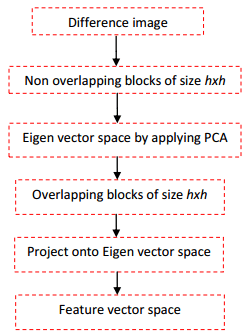

Function find_FVS() determines the feature vector space for us. The function is similar to find_vector_set(), but extracts overlapping blocks from the difference image.

In [ ]:
def find_FVS(EVS, diff_image, mean_vec, new):
 
    i = 2
    feature_vector_set = []
 
    while i < new[0] - 2:
        j = 2
        while j < new[1] - 2:
            block = diff_image[i-2:i+3, j-2:j+3]
            feature = block.flatten()
            feature_vector_set.append(feature)
            j = j+1
        i = i+1
 
    FVS = np.dot(feature_vector_set, EVS)
    FVS = FVS - mean_vec
    return FVS

new=new_size
FVS=find_FVS(EVS, diff_image, mean_vec, new)

The feature vectors for the pixels now lie in a space where their variance has been maximized. This will help the subsequent step of clustering to better categorize the pixels into the 2 classes – changed pixels (pix_c ) and unchanged pixels (pix_u ).

# Clustering of the feature vector space, and change map

The feature vectors for the pixels carry information whether the pixels have characteristics of a changed pixel or an unchanged one. Having constructed the feature vector space, we now need to cluster it so that the pixels can be grouped into two disjoint classes. We will be using the K-means algorithm to do that.

In [ ]:
from sklearn.cluster import KMeans
from collections import Counter
 
def clustering(FVS, components, new):
 
    kmeans = KMeans(components, verbose = 0)
    kmeans.fit(FVS)
    output = kmeans.predict(FVS)
    count  = Counter(output)
 
    least_index = min(count, key = count.get)
    change_map  = np.reshape(output,(new[0] - 4, new[1] - 4))
    return least_index, change_map
components=3
clustering(FVS,components, new)

(0, array([[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]], dtype=int32))

We have randomly chosen 3 clusters here , how to decide which pixels belong to the changed class?

-It can be postulated that the cluster which contains the lowest number of pixels (denoted by variable least_index) is the cluster denoting the changed class, since the background remains more or less the same in satellite images and the changes occurred are comparatively less.

-The mean of this cluster will be the highest. The reason behind the highest value of mean for that cluster is that the values of the difference image pixels in a region where some changes have occurred are higher than the values of pixels in the regions where there is no change. 

# Building the change map 

A binary image to show the output of change detection. 

-The background black 

-Changes in white

In [ ]:
import cv2
least_index, change_map = clustering(FVS, components, new_size)
change_map[change_map == least_index] = 255
change_map[change_map != 255] = 0

change_map = change_map.astype(np.uint8)
kernel     = np.asarray(((0,0,1,0,0),
                             (0,1,1,1,0),
                             (1,1,1,1,1),
                             (0,1,1,1,0),
                             (0,0,1,0,0)), dtype=np.uint8)

cleanChangeMap = cv2.erode(change_map,kernel)
imsave("changemap.jpg", change_map)
imsave("cleanchangemap.jpg", cleanChangeMap)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning:     `imsave` is deprecated!
    `imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imwrite`` instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DeprecationWarning:     `imsave` is deprecated!
    `imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imwrite`` instead.
  from ipykernel import kernelapp as app


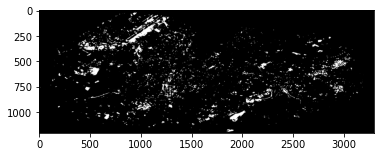

In [ ]:
import matplotlib.pyplot as plt
A=cv2.imread("/content/changemap.jpg")
plt.imshow(A)
plt.show()
